# Experiment 2: Adding a Missing Indicator for Missing Values

## Installing and importing packages

In [1]:
%pip install mlflow dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.2/258.2 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 629.7/629.7 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import mlflow

import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler, PowerTransformer, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from data_cleaning_utils import clean_data

set_config(transform_output="pandas")

## Connecting with dagshub

In [3]:
import dagshub
dagshub.init(repo_owner='SushrutGaikwad', repo_name='swiggy-delivery-time-prediction', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=e4a8cef1-ff0a-47e3-afa7-97961d5f18cd&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=ea1d3bdfb9f8a1fca66e5834485b84b21a4f9b22d4d5d658273b41d25256dcca




Accessing as SushrutGaikwad

Initialized MLflow to track repo "SushrutGaikwad/swiggy-delivery-time-prediction"

Repository SushrutGaikwad/swiggy-delivery-time-prediction initialized!

## Loading and cleaning the data

In [4]:
df = pd.read_csv("/content/swiggy.csv")
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [5]:
df = clean_data(df=df)
df.head()

,rider_id,age,ratings,restaurant_latitude,restaurant_longitude,delivery_latitude,delivery_longitude,order_date,weather,traffic,...,city_name,distance,distance_type,order_day,order_month,order_day_of_week,order_day_is_weekend,pickup_time_minutes,order_time_hour,order_time_of_day
0,INDORES13DEL02,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,sunny,high,...,INDO,3.025149,short,19,3,saturday,1,15.0,11.0,morning
1,BANGRES18DEL02,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,stormy,jam,...,BANG,20.183530,very_long,25,3,friday,0,5.0,19.0,evening
2,BANGRES19DEL01,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,sandstorms,low,...,BANG,1.552758,short,19,3,saturday,1,15.0,8.0,morning
3,COIMBRES13DEL02,38.0,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,sunny,medium,...,COIMB,7.790401,medium,5,4,tuesday,0,10.0,18.0,evening
4,CHENRES12DEL01,32.0,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,cloudy,high,...,CHEN,6.210138,medium,26,3,saturday,1,15.0,13.0,afternoon


## Dropping unnecessary columns

We will now drop the columns that we, during EDA, identified to not affect our target significantly.

In [6]:
df.columns

Index(['rider_id', 'age', 'ratings', 'restaurant_latitude',
       'restaurant_longitude', 'delivery_latitude', 'delivery_longitude',
       'order_date', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'city_name', 'distance', 'distance_type',
       'order_day', 'order_month', 'order_day_of_week', 'order_day_is_weekend',
       'pickup_time_minutes', 'order_time_hour', 'order_time_of_day'],
      dtype='object')

In [7]:
cols_to_drop = [
    'rider_id',
    'restaurant_latitude',
    'restaurant_longitude',
    'delivery_latitude',
    'delivery_longitude',
    'order_date',
    'order_time_hour',
    'order_day',
    'city_name',
    'order_day_of_week',
    'order_month',
]

df.drop(columns=cols_to_drop, inplace=True)
df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


In [8]:
df.shape

(45502, 16)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45502 entries, 0 to 45592
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   age                   43648 non-null  float64 
 1   ratings               43594 non-null  float64 
 2   weather               44977 non-null  object  
 3   traffic               44992 non-null  object  
 4   vehicle_condition     45502 non-null  int64   
 5   type_of_order         45502 non-null  object  
 6   type_of_vehicle       45502 non-null  object  
 7   multiple_deliveries   44509 non-null  float64 
 8   festival              45274 non-null  object  
 9   city_type             44304 non-null  object  
 10  time_taken            45502 non-null  int64   
 11  distance              41872 non-null  float64 
 12  distance_type         41872 non-null  category
 13  order_day_is_weekend  45502 non-null  int64   
 14  pickup_time_minutes   43862 non-null  float64 
 15  order_t

## Checking for duplicates

In [10]:
df.duplicated().sum()

0

## Missing values

In [11]:
df.isna().sum()

,0
age,1854
ratings,1908
weather,525
traffic,510
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,993
festival,228
city_type,1198


In [12]:
df.isna().sum().sum()

17756

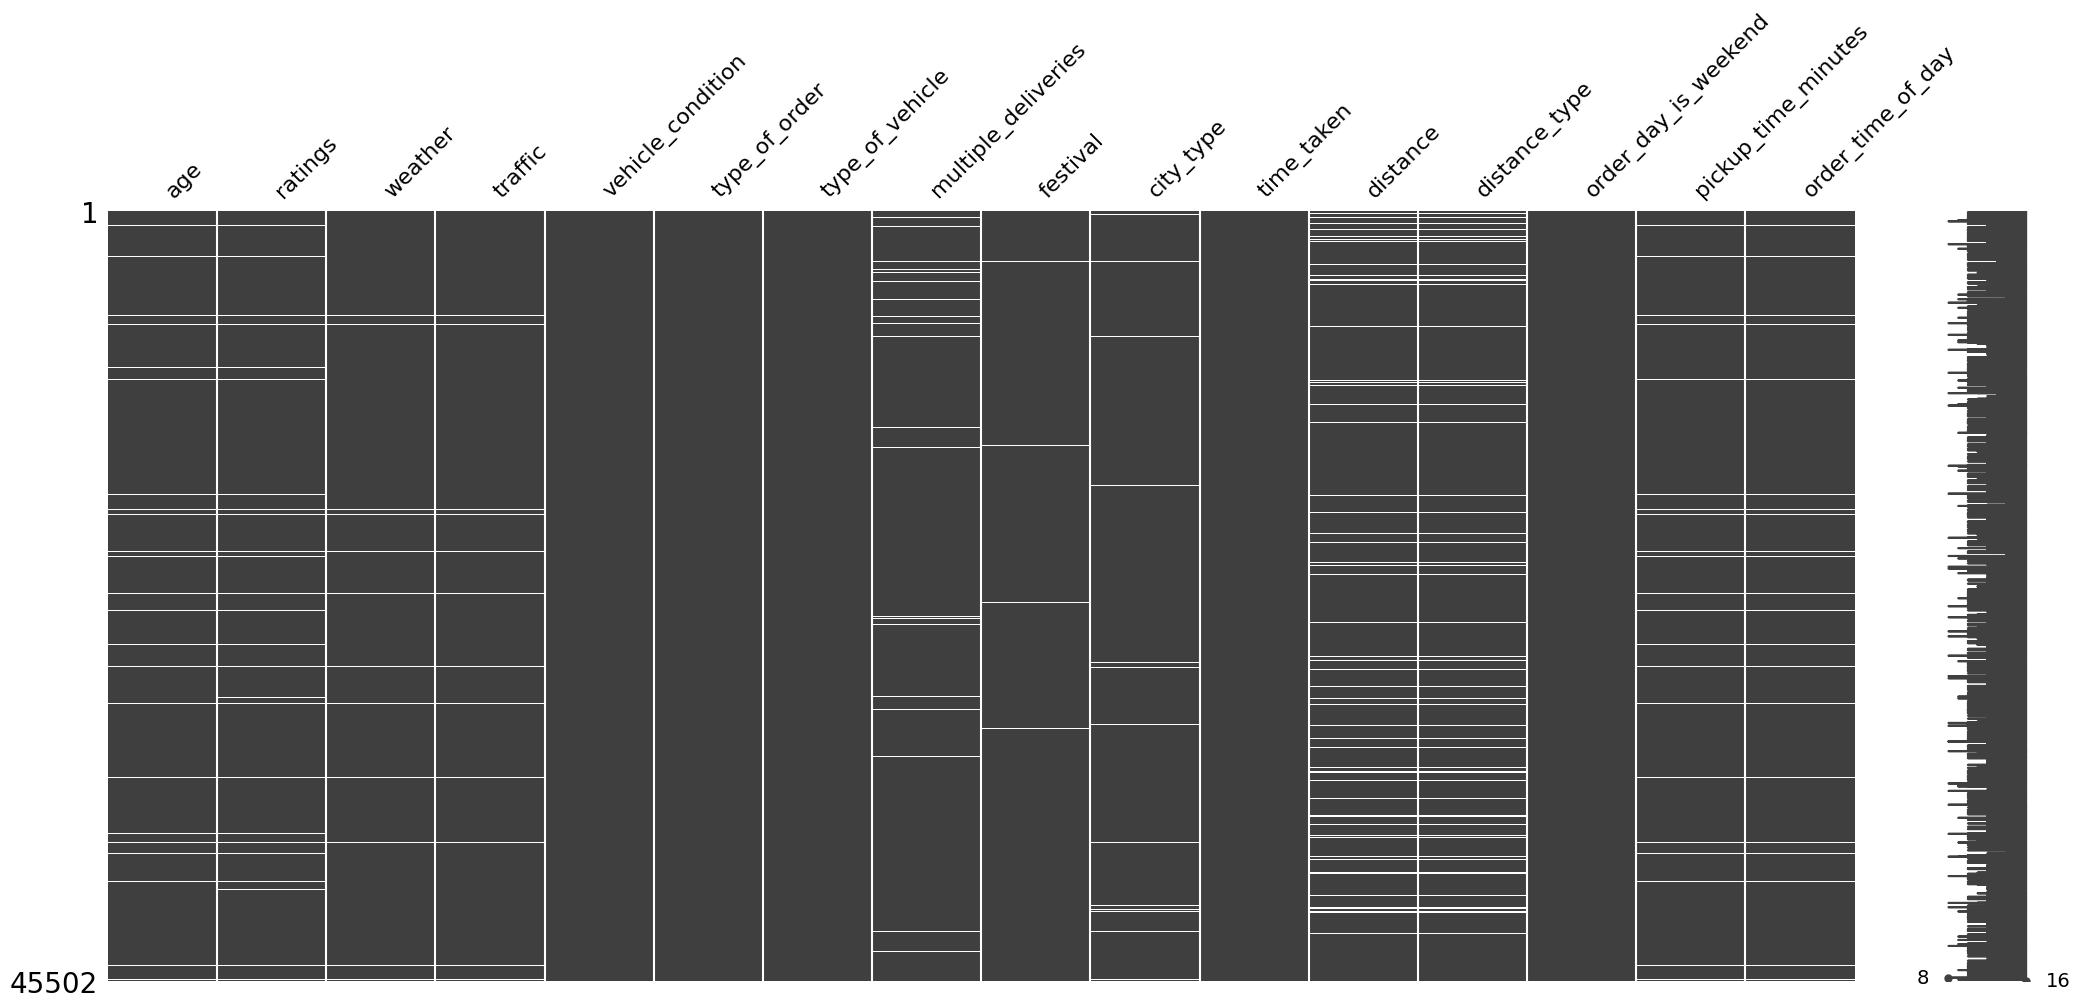

In [13]:
msno.matrix(df);

In [14]:
missing_cols = df.columns[df.isnull().any()]
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'distance', 'distance_type',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

## Imputing missing values

### Input-output split

In [15]:
temp_df = df.copy()
temp_df.head()

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,distance,distance_type,order_day_is_weekend,pickup_time_minutes,order_time_of_day
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,3.025149,short,1,15.0,morning
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,20.183530,very_long,0,5.0,evening
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1.552758,short,1,15.0,morning
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,7.790401,medium,0,10.0,evening
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,6.210138,medium,1,15.0,afternoon


In [16]:
X = temp_df.drop(columns=['time_taken'])
y = temp_df['time_taken']

### Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_train.shape = (36401, 15)
X_test.shape = (9101, 15)


### Checking for missing values in the training data

In [19]:
X_train.isna().sum()

,0
age,1470
ratings,1510
weather,421
traffic,407
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,795
festival,188
city_type,968


In [20]:
X_train.isna().sum().sum()

14217

In [21]:
missing_cols

Index(['age', 'ratings', 'weather', 'traffic', 'multiple_deliveries',
       'festival', 'city_type', 'distance', 'distance_type',
       'pickup_time_minutes', 'order_time_of_day'],
      dtype='object')

#### Percentage of missing rows in the training data

In [22]:
missing_pct = X_train.isnull().any(axis=1).mean() * 100
print(f"{missing_pct:.2f}% of rows in the training data have missing values.")

16.44% of rows in the training data have missing values.


### Transforming the target

In [23]:
pt = PowerTransformer(method='yeo-johnson')

y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.transform(y_test.values.reshape(-1, 1))

### Imputation pipeline

In [24]:
num_cols = ['age', 'ratings', 'pickup_time_minutes', 'distance']

nominal_cat_cols = [
    'weather',
    'type_of_order',
    'type_of_vehicle',
    'festival',
    'city_type',
    'order_day_is_weekend',
    'order_time_of_day',
]

ordinal_cat_cols = ['traffic', 'distance_type']

In [25]:
X_train.isna().sum()

,0
age,1470
ratings,1510
weather,421
traffic,407
vehicle_condition,0
type_of_order,0
type_of_vehicle,0
multiple_deliveries,795
festival,188
city_type,968


#### Getting the column names

In [26]:
features_to_fill_mode = [
    'multiple_deliveries',
    'festival',
    'city_type',
]

features_to_fill_missing_ind = [col for col in nominal_cat_cols if col not in features_to_fill_mode]
features_to_fill_missing_ind

['weather',
 'type_of_order',
 'type_of_vehicle',
 'order_day_is_weekend',
 'order_time_of_day']

#### Simple imputer column transformer

In [27]:
simple_imputer = ColumnTransformer(
    transformers=[
        ("mode_imputer", SimpleImputer(strategy="most_frequent", add_indicator=True), features_to_fill_mode),
        ("missing_ind", SimpleImputer(strategy="constant", fill_value="missing", add_indicator=True), features_to_fill_missing_ind)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False
)

simple_imputer

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('mode_imputer',
                                 SimpleImputer(add_indicator=True,
                                               strategy='most_frequent'),
                                 ['multiple_deliveries', 'festival',
                                  'city_type']),
                                ('missing_ind',
                                 SimpleImputer(add_indicator=True,
                                               fill_value='missing',
                                               strategy='constant'),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'order_day_is_weekend',
                                  'order_time_of_day'])],
                  verbose_feature_names_out=False)

In [28]:
simple_imputer.fit_transform(X_train)

,multiple_deliveries,festival,city_type,missingindicator_multiple_deliveries,missingindicator_festival,missingindicator_city_type,weather,type_of_order,type_of_vehicle,order_day_is_weekend,order_time_of_day,missingindicator_weather,missingindicator_order_time_of_day,age,ratings,traffic,vehicle_condition,distance,distance_type,pickup_time_minutes
11047,1.0,no,metropolitian,False,False,False,windy,snack,electric_scooter,0,night,False,False,26.0,4.7,jam,2,9.177684,medium,10.0
15692,1.0,no,metropolitian,False,False,False,windy,drinks,motorcycle,0,afternoon,False,False,21.0,4.9,medium,2,6.081536,medium,5.0
14499,1.0,no,metropolitian,False,False,False,stormy,meal,scooter,1,missing,False,True,NaN,NaN,low,2,1.554563,short,NaN
29258,1.0,no,metropolitian,False,False,False,windy,buffet,motorcycle,0,evening,False,False,32.0,4.7,medium,0,20.852271,very_long,15.0
22554,0.0,no,urban,False,False,False,sandstorms,meal,scooter,0,night,False,False,34.0,4.9,jam,1,9.056096,medium,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.0,no,metropolitian,False,False,False,sandstorms,meal,scooter,0,evening,False,False,29.0,4.7,jam,2,12.464367,long,5.0
44821,0.0,no,urban,False,False,False,cloudy,buffet,motorcycle,0,morning,False,False,36.0,4.8,low,0,1.520432,short,10.0
38234,0.0,no,metropolitian,False,False,False,fog,buffet,scooter,0,evening,False,False,36.0,4.4,jam,1,NaN,NaN,10.0
860,1.0,no,metropolitian,False,False,False,windy,meal,scooter,1,evening,False,False,25.0,4.9,medium,2,7.760938,medium,5.0


In [29]:
simple_imputer.fit_transform(X_train).isna().sum()

,0
multiple_deliveries,0
festival,0
city_type,0
missingindicator_multiple_deliveries,0
missingindicator_festival,0
missingindicator_city_type,0
weather,0
type_of_order,0
type_of_vehicle,0
order_day_is_weekend,0


In [30]:
knn_imputer = KNNImputer(n_neighbors=5)

In [31]:
num_cols = ['age', 'ratings', 'pickup_time_minutes', 'distance']

nominal_cat_cols = [
    'weather',
    'type_of_order',
    'type_of_vehicle',
    'festival',
    'city_type',
    'order_day_is_weekend',
    'order_time_of_day',
]

ordinal_cat_cols = ['traffic', 'distance_type']

In [32]:
for col in ordinal_cat_cols:
    print(f"{col}: {X_train[col].unique()}")

traffic: ['jam' 'medium' 'low' 'high' nan]
distance_type: ['medium', 'short', 'very_long', 'long', NaN]
Categories (4, object): ['short' < 'medium' < 'long' < 'very_long']


In [33]:
traffic_order = ['low', 'medium', 'high', 'jam']
distance_type_order = ['short', 'medium', 'long', 'very_long']

#### Creating the preprocessor

In [34]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_cols),
        ("nominal_encoder", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False), nominal_cat_cols),
        ("ordinal_encoder", OrdinalEncoder(categories=[traffic_order, distance_type_order], encoded_missing_value=-999, handle_unknown="use_encoded_value", unknown_value=-1), ordinal_cat_cols)
    ],
    remainder="passthrough",
    n_jobs=-1,
    force_int_remainder_cols=False,
    verbose_feature_names_out=False,
)

preprocessor

ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                  remainder='passthrough',
                  transformers=[('scaler', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encoder',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type',
                                  'order_day_is_weekend',
                                  'order_time_of_day']),
                                ('ordinal_encoder',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']],
                                                encoded_missing_value=-999,
                                                handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [35]:
preprocessor.fit_transform(X_train)

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,weather_nan,...,order_day_is_weekend_1,order_time_of_day_afternoon,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,order_time_of_day_nan,traffic,distance_type,vehicle_condition,multiple_deliveries
11047,0.315789,0.88,0.5,0.395429,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,2,1.0
15692,0.052632,0.96,0.0,0.236688,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2,1.0
14499,NaN,NaN,NaN,0.004588,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,1.0
29258,0.631579,0.88,1.0,0.993990,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,0,1.0
22554,0.736842,0.96,0.0,0.389195,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11303,0.473684,0.88,0.0,0.563939,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,0.0
44821,0.842105,0.92,0.5,0.002839,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
38234,0.842105,0.76,0.5,NaN,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,-1.0,1,0.0
860,0.263158,0.96,0.0,0.322792,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,2,1.0


#### Preprocessing pipeline

In [36]:
preprocessing_pipeline = Pipeline(
    steps=[
        ("simple_imputer", simple_imputer),
        ("preprocessor", preprocessor),
        ("knn_imputer", knn_imputer)
    ]
)

preprocessing_pipeline

Pipeline(steps=[('simple_imputer',
                 ColumnTransformer(force_int_remainder_cols=False, n_jobs=-1,
                                   remainder='passthrough',
                                   transformers=[('mode_imputer',
                                                  SimpleImputer(add_indicator=True,
                                                                strategy='most_frequent'),
                                                  ['multiple_deliveries',
                                                   'festival', 'city_type']),
                                                 ('missing_ind',
                                                  SimpleImputer(add_indicator=True,
                                                                fill_value='missing',
                                                                strategy='constant'),
                                                  ['weat...
                                                   'festival', 'city_type',
                                                   'order_day_is_weekend',
                                                   'order_time_of_day']),
                                                 ('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['low',
                                                                              'medium',
                                                                              'high',
                                                                              'jam'],
                                                                             ['short',
                                                                              'medium',
                                                                              'long',
                                                                              'very_long']],
                                                                 encoded_missing_value=-999,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['traffic',
                                                   'distance_type'])],
                                   verbose_feature_names_out=False)),
                ('knn_imputer', KNNImputer())])

#### Creating the model pipeline

In [37]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

model_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessing_pipeline),
        ("model", rf)
    ]
)

model_pipeline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_ind',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='miss...
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [38]:
model_pipeline.fit(X_train, y_train_transformed.values.ravel())

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('simple_imputer',
                                  ColumnTransformer(force_int_remainder_cols=False,
                                                    n_jobs=-1,
                                                    remainder='passthrough',
                                                    transformers=[('mode_imputer',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='most_frequent'),
                                                                   ['multiple_deliveries',
                                                                    'festival',
                                                                    'city_type']),
                                                                  ('missing_ind',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 fill_value='miss...
                                                                  ('ordinal_encoder',
                                                                   OrdinalEncoder(categories=[['low',
                                                                                               'medium',
                                                                                               'high',
                                                                                               'jam'],
                                                                                              ['short',
                                                                                               'medium',
                                                                                               'long',
                                                                                               'very_long']],
                                                                                  encoded_missing_value=-999,
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1),
                                                                   ['traffic',
                                                                    'distance_type'])],
                                                    verbose_feature_names_out=False)),
                                 ('knn_imputer', KNNImputer())])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

#### Predictions

In [39]:
y_pred_train = model_pipeline.predict(X_train)
y_pred_test = model_pipeline.predict(X_test)

In [40]:
y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))

#### Error metrics

In [41]:
print(f"The train MAE is {mean_absolute_error(y_train, y_pred_train):.2f} minutes")
print(f"The test MAE is {mean_absolute_error(y_test, y_pred_test):.2f} minutes")

The train MAE is 1.21 minutes
The test MAE is 3.27 minutes


In [42]:
print(f"The train R2 is {r2_score(y_train, y_pred_train):.2f}")
print(f"The test R2 is {r2_score(y_test, y_pred_test):.2f}")

The train R2 is 0.97
The test R2 is 0.81


In [43]:
cv_scores = cross_val_score(
    model_pipeline, X_train, y_train_transformed.values.ravel(),
    cv=5, scoring="r2", n_jobs=-1
)
cv_scores

array([0.78257996, 0.79035383, 0.78744405, 0.7832942 , 0.78665712])

In [44]:
cv_scores.mean()

0.786065833537977

#### Logging on MLFlow

In [45]:
mlflow.set_tracking_uri("https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow")
mlflow.set_experiment("Exp 1 and 2: Keeping vs. dropping missing values and adding missing indicator")

<Experiment: artifact_location='mlflow-artifacts:/3b5b62d26dbd4d189c6fb75a1d06f6f9', creation_time=1736695458086, experiment_id='6', last_update_time=1736695458086, lifecycle_stage='active', name='Exp 1 and 2: Keeping vs. dropping missing values and adding missing indicator', tags={}>

In [46]:
with mlflow.start_run(run_name="Missing indicator for missing values"):
    # Logging experiment type
    mlflow.log_param("experiment_type", "Missing indicator for missing values")
    # Logging model parameters
    mlflow.log_params(rf.get_params())

    # Logging metrics
    mlflow.log_metric("training_mae", mean_absolute_error(y_true=y_train, y_pred=y_pred_train))
    mlflow.log_metric("test_mae", mean_absolute_error(y_true=y_test, y_pred=y_pred_test))
    mlflow.log_metric("training_r2", r2_score(y_true=y_train, y_pred=y_pred_train))
    mlflow.log_metric("test_r2", r2_score(y_true=y_test, y_pred=y_pred_test))
    mlflow.log_metric("mean_cv_r2", cv_scores.mean())

🏃 View run Missing indicator for missing values at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/6/runs/bc6050718f6c45e0997b59d9cc6b4841
🧪 View experiment at: https://dagshub.com/SushrutGaikwad/swiggy-delivery-time-prediction.mlflow/#/experiments/6
